In [38]:
import devhgcaltruth as ht
import uptools
import numpy as np

The downloaded ntuples contain simulated events for 'particle guns'.
This means two back-to-back particles were shot into the 'positive' and 'negative' endcaps of HGCAL at some random angle.
Let's load an event from a .root file:

In [43]:
ntup = 'ntups/NTUPLE_event1001_pdgid211_100GeV_Mar26_finecalo_n10.root'
event = uptools.get_event_rootfile(ntup, 1)

[cernsso|    INFO|2021-05-13 11:30:51|__init__]: Using tree ntupler/tree


The event data is easy enough to follow. It is a dict-like structure, containing information about tracks and hits:

In [44]:
list(event.keys())

[b'event_number',
 b'simtrack_x',
 b'simtrack_y',
 b'simtrack_z',
 b'simtrack_pt',
 b'simtrack_eta',
 b'simtrack_phi',
 b'simtrack_energy',
 b'simtrack_mass',
 b'simtrack_trackid',
 b'simtrack_vertexindex',
 b'simtrack_pdgid',
 b'simtrack_crossedboundary',
 b'simtrack_boundary_x',
 b'simtrack_boundary_y',
 b'simtrack_boundary_z',
 b'simtrack_boundary_t',
 b'simtrack_boundary_pt',
 b'simtrack_boundary_eta',
 b'simtrack_boundary_phi',
 b'simtrack_boundary_energy',
 b'simtrack_boundary_mass',
 b'simtrack_vertex_id',
 b'simtrack_vertex_x',
 b'simtrack_vertex_y',
 b'simtrack_vertex_z',
 b'simtrack_vertex_t',
 b'simtrack_vertex_processtype',
 b'simtrack_parenttrackid',
 b'simtrack_noparent',
 b'simtrack_parentexists',
 b'simtrack_hashits',
 b'simhit_detid',
 b'simhit_x',
 b'simhit_y',
 b'simhit_z',
 b'simhit_layer',
 b'simhit_energy',
 b'simhit_pdgid',
 b'simhit_emenergy',
 b'simhit_time',
 b'simhit_trackid',
 b'simhit_inEE',
 b'simhit_inHSi',
 b'simhit_inHsc']

As you can see, both endcaps are mixed now:

In [45]:
event[b'simhit_z']

array([-322.06827, -322.06827, -322.06827, ...,  470.1995 ,  478.7495 ,
        478.7495 ], dtype=float32)

Let's make a quick plot of all the hits.
For 3D plotting purposes it's typically easier to transform `(x, y, z) --> (z, x, y)`;
This conforms a little better with the traditional view of the detector, where the z-axis is horizontal and the xy-plane is the 'vertical' transverse plane.

Text(0.5, 0, 'y')

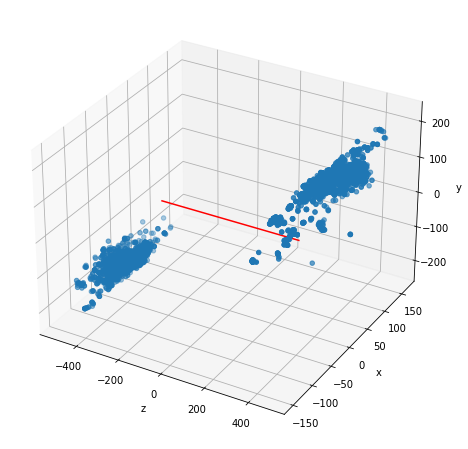

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111 , projection='3d')
ax.scatter(event[b'simhit_z'], event[b'simhit_x'], event[b'simhit_y'])
ax.plot([-320., 320.], [0,0], [0,0], color='r') # This is the beamline
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')

As you can see, the hits lie between `320.5 < abs(z) < 513.5`, which is where HGCAL is.

We could go a little further, and plot all the hits and tracks. A simulated 'track' refers to the simulated traversal of a particle through the detector (processed by Geant). A track can produce hits, and daughter tracks that can in turn produce hits.

Text(0.5, 0, 'y')

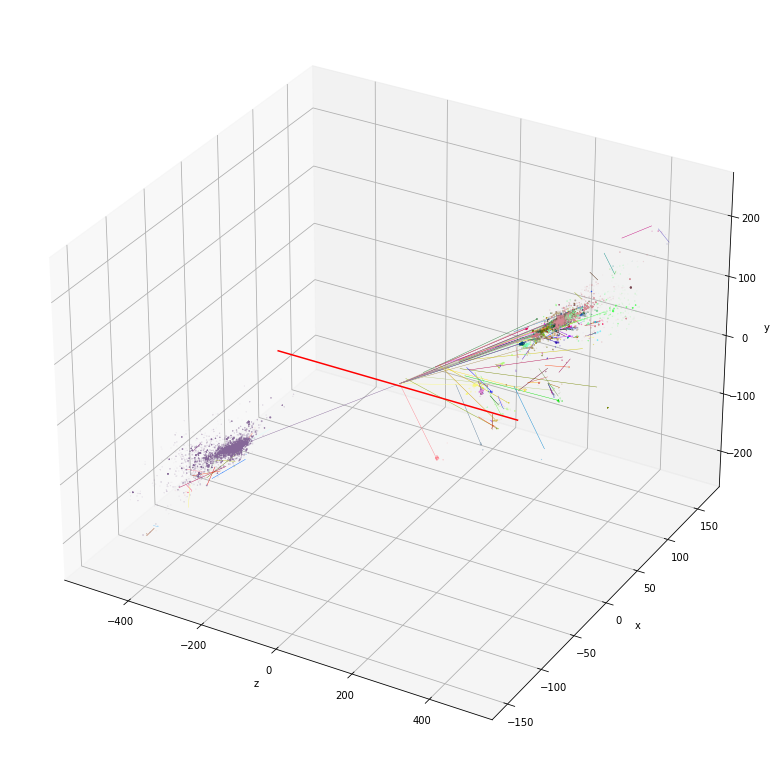

In [63]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111 , projection='3d')
colorwheel = ht.IDColor() # Returns a consistent color when you call colorwheel(object)

# Find all the different track ids that have hits:
track_ids = np.unique(event[b'simhit_trackid'])

# Plot the hits, where the color corresponds to the track that created the hits
for track_id in track_ids:
    select_hits = event[b'simhit_trackid'] == track_id
    ax.scatter(
        event[b'simhit_z'][select_hits], event[b'simhit_x'][select_hits], event[b'simhit_y'][select_hits],
        c = colorwheel(track_id),
        s = 500.*event[b'simhit_energy'][select_hits]
        )

# Also plot the tracks
for i_track in range(len(event[b'simtrack_trackid'])):
    track_id = event[b'simtrack_trackid'][i_track]
    if not track_id in track_ids: continue # Skip the tracks that do not have hits, to avoid overcrowding
    ax.plot(
        [event[b'simtrack_vertex_z'][i_track], event[b'simtrack_z'][i_track]],
        [event[b'simtrack_vertex_x'][i_track], event[b'simtrack_x'][i_track]],
        [event[b'simtrack_vertex_y'][i_track], event[b'simtrack_y'][i_track]],
        c = colorwheel(track_id), linewidth=.4
        )

ax.plot([-320., 320.], [0,0], [0,0], color='r') # This is the beamline
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')

We're starting to see a bit more structure in the event. The negative endcap (z<0) is simple enough: All the hits are associated with one track, namely the initial pion from the pion gun.

In the positive endcap however, the pion decayed before reaching HGCAL, and the event quickly becomes much messier. All sorts of daughter tracks, consisting of both hadrons and electromagnetic particles, have left hits in the detector.

In order to explore the events in more detail, it makes sense to think of the events as a 'decay tree' that have the initial pion track as a root. The `devhgcaltruth` has a tree-like datastructure that can help with this:

In [79]:
root = ht.build_tree(event)
print(type(root))
root.print()

<class 'devhgcaltruth.trees.Track'>
0 E=0.00 pdg=0  
__1 E=284.25 pdg=211  
____346664 E=84.87 pdg=2212  
______630282 E=84.74 pdg=2212  
________630317 E=1.98 pdg=2112 nhits=22 X
________630319 E=1.31 pdg=2112  
__________738024 E=0.17 pdg=111  
____________738031 E=0.09 pdg=22 nhits=3 X
________630320 E=1.56 pdg=211 nhits=55 X
________630321 E=0.88 pdg=-211 nhits=12 X
________630322 E=3.16 pdg=2112 nhits=23 X
________630323 E=3.48 pdg=111  
__________728693 E=1.86 pdg=22  
____________731376 E=1.52 pdg=11  
______________731882 E=0.90 pdg=22 nhits=72 X
______________731883 E=0.59 pdg=11 nhits=32 X
____________731377 E=0.34 pdg=-11 nhits=34 X
__________728694 E=1.62 pdg=22 nhits=94 X
________630324 E=1.20 pdg=2112 nhits=2 X
________630325 E=0.99 pdg=211 nhits=18 X
________630327 E=1.14 pdg=2212 nhits=2 X
________630330 E=0.46 pdg=111  
__________727068 E=0.28 pdg=22  
____________727359 E=0.19 pdg=11  
______________727466 E=0.02 pdg=22 nhits=4 X
______________727469 E=0.11 pdg=22 nhi

The 'root' is simply a placeholder; the immediate children, track 1 and 2, are the initial pions from the particle gun. As you can see, all other tracks are (grand)daughter tracks of these two tracks.

Let's focus on the positive endcap pion, and let's focus on the tracks that actually leave hits in the detector. The following two functions split off the positive endcap, and remove a lot of hitless tracks that are used by Geant as intermediate steps to get to the final hit-producing tracks:

In [91]:
root = ht.trees.trim_tree(ht.split_endcaps(root)[0]) # Index 1 would be the negative endcap
root.print()

0 E=0.00 pdg=0  
__346678 E=41.15 pdg=-2212 nhits=1553 X
____487811 E=0.97 pdg=2112 nhits=8 X
______487822 E=0.94 pdg=2112 nhits=8 X
____482889 E=0.94 pdg=2112 nhits=1 X
____480086 E=0.94 pdg=2112 nhits=1 X
__346680 E=1.47 pdg=22 nhits=127 X
__346682 E=4.81 pdg=-211 nhits=112 X
__346684 E=8.57 pdg=211 nhits=230 X
__346685 E=4.79 pdg=-211 nhits=167 X
____350081 E=1.10 pdg=2112 nhits=12 X
______350183 E=0.94 pdg=2112 nhits=4 X
__630317 E=1.98 pdg=2112 nhits=22 X
__630320 E=1.56 pdg=211 nhits=55 X
__630321 E=0.88 pdg=-211 nhits=12 X
__630322 E=3.16 pdg=2112 nhits=23 X
__630324 E=1.20 pdg=2112 nhits=2 X
__630325 E=0.99 pdg=211 nhits=18 X
__630327 E=1.14 pdg=2212 nhits=2 X
__630331 E=1.15 pdg=2212 nhits=4 X
__630332 E=16.26 pdg=-211 nhits=581 X
__630334 E=19.59 pdg=211 nhits=992 X
__630336 E=1.61 pdg=-211 nhits=31 X
__630338 E=5.63 pdg=211 nhits=153 X
__630339 E=0.86 pdg=-211 nhits=13 X
__630344 E=1.00 pdg=2112 nhits=1 X
__738031 E=0.09 pdg=22 nhits=3 X
__728694 E=1.62 pdg=22 nhits=94 X
__7

Let's make a 3D visualization with `plotly`:

In [98]:
import plotly.graph_objects as go

def prepare_data_3d_plot(root):
    data = []
    for track in root.traverse():
        if track.nhits == 0: continue # Skip hitless tracks
        hits = track.nphits() # Collects the hits of the track in a numpy array

        # Draw the hits as a 3D point cloud
        data.append(go.Scatter3d(
            x=hits[:,2], y=hits[:,0], z=hits[:,1],
            mode='markers', 
            marker=dict(
                line=dict(width=0),
                color=colorwheel(int(track.trackid)),
                size=2.
                ),
            hovertemplate=(
                'x: %{{y:0.2f}}<br>y: %{{z:0.2f}}<br>z: %{{x:0.2f}}<br>pdgId: {}<br>'
                .format(track.pdgid)
                ),
            name=str(int(track.trackid)),
            ))
    return data

In [ ]:
fig = go.Figure(prepare_data_3d_plot(root))
# Change the axis labels to our rotated definition
fig.update_layout(scene=dict(xaxis_title='z', yaxis_title='x', zaxis_title='y',))

Look around in the plot (it should be rotatable with your mouse). You can zoom, hold control to move the axes around, single-click on legend items to turn them on/off, and double-click on legend items to turn all other items on/off. You should see some clear electromagnetic showers (they start on the frontface of HGCAL, and look a bit more 'oval-y'), and some obvious hadronic activity, which can decay at quite some depth into the detector.

This is a very detailed view of the decay tree. In real life, HGCAL won't be able to reconstruct showers at such a fine level; some things are simply too close to one another to disentangle in an unlabeled dataset (i.e. one you would get in an actual measurement). This means we need to 'coarsen' the decay tree to a level that looks reasonably reconstructable.

The `devhgcaltruth` package contains a bunch of merging algorithms that attempt to do this. The following algorithm simply looks at the distance between the centroids of the hit cloud per track, and if two centriods are close enough (defined here as 5.0 cm), the two hit clouds are merged.

In [103]:
merged = ht.trees.merging_algo(root, default_min_r=5.)

merging iterations: 4it [00:12,  3.24s/it]                       


Let's plot our merged event:

In [ ]:
fig = go.Figure(prepare_data_3d_plot(merged))
# Change the axis labels to our rotated definition
fig.update_layout(scene=dict(xaxis_title='z', yaxis_title='x', zaxis_title='y',))

If you focus your attention on the very busy part in the middle (rotate your view a bit), you'll see that this already looks a lot more reasonable than the very fine decay tree a few cells above.

That's the end of this example!